# MS0XX Preprocess

Created: XX/XX/20XX \
Updated: XX/XX/20XX \
*major updates following LFPAnalysis merge re factor pre processing and artifact detection*

In [200]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
from ast import literal_eval


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS002'
subj_format = ['edf']
subj_site = ['MSSM']


In [50]:
#### print date of last run
date = datetime.date.today().strftime('%m%d%Y')
print(date)

05092024


# Make mne_data


### Load and resample data


In [6]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/raw/MS002_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2219007  =      0.000 ...  2166.999 secs...


In [7]:
mne_data

<RawEDF | MS002_SWB.edf, 276 x 2219008 (2167.0 s), ~4.56 GB, data loaded>

In [9]:
# mne_data.ch_names

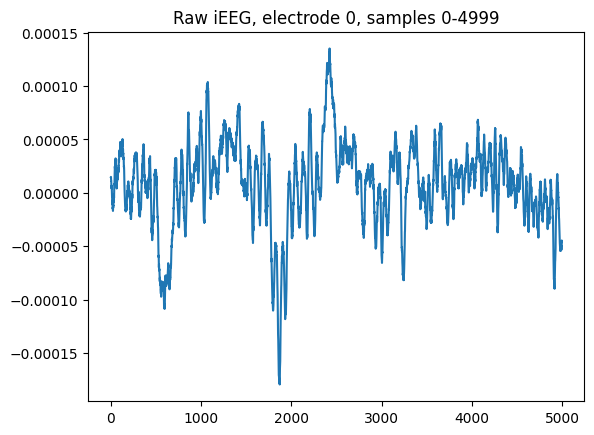

In [10]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [13]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:   53.4s finished


<RawEDF | MS002_SWB.edf, 276 x 1083500 (2167.0 s), ~2.23 GB, data loaded>

### Notch filter line noise

In [14]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:    9.3s finished


<RawEDF | MS002_SWB.edf, 276 x 1083500 (2167.0 s), ~2.23 GB, data loaded>

### Photodiode
- examine photodiode 

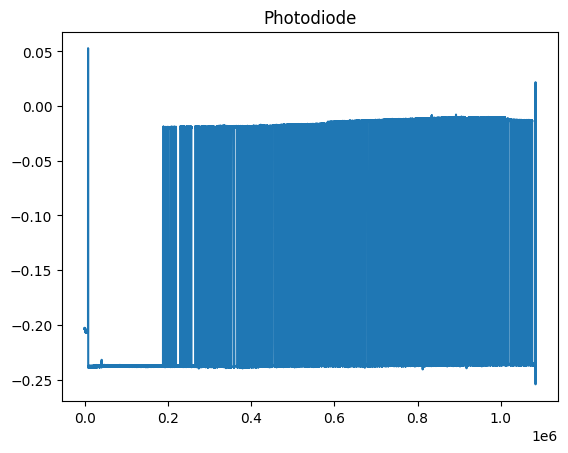

In [15]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [16]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/photodiode.fif
[done]


In [17]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS002_SWB.edf, 275 x 1083500 (2167.0 s), ~2.22 GB, data loaded>

### Anatomical Localization

In [18]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS002_SWB.edf, 275 x 1083500 (2167.0 s), ~2.22 GB, data loaded>

In [19]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination
0,LaCaS1,A32sg_L,-6.784557,49.555827,0.149337,-6.382462,37.158688,-3.130044,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus D,NaN
1,LaCaS10,A9l_L,-8.380923,61.155821,43.676991,-8.220073,48.757099,44.868611,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Medial Gyrus,L SFG,Left superior frontal gyrus 2 C,NaN
2,LaCaS11,A9l_L,-8.780014,62.355821,48.469026,-8.542609,49.887710,50.203768,Unknown,Left SFG superior frontal gyrus,Unknown,L Superior Medial Gyrus,L SFG,Left superior frontal gyrus 2 C,OOB
3,LaCaS12,Unknown,-8.780014,63.555820,53.261062,-8.436667,51.044299,55.539730,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB
4,LaCaS2,A32sg_L,-6.784557,50.755827,4.941372,-6.368174,38.606223,2.270621,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,RmOIF5,A12/47o_R,33.922762,42.355831,-8.636061,34.666463,28.882016,-13.444118,White,Right Cerebral White Matter,Unknown,R IFG (p Orbitalis),R OrG,Right frontal orbital 4 D,WM
154,RmOIF6,A12/47l_R,37.913675,41.555831,-6.240044,38.716568,28.139395,-11.063832,Gray,Right Cerebral White Matter,Unknown,R IFG (p Orbitalis),R OrG,Right frontal orbital 4 D,NaN
155,RmOIF7,A12/47l_R,41.904589,40.755832,-3.844026,42.794042,27.279509,-8.584441,Gray,Right OrIFG orbital part of the inferior front...,Unknown,R IFG (p Orbitalis),R OrG,Right pars orbitalis C,NaN
156,RmOIF8,A12/47l_R,46.294594,39.555832,-1.048672,47.308597,25.926043,-5.816665,Gray,Right OrIFG orbital part of the inferior front...,Unknown,R IFG (p Orbitalis),R OrG,Right middle pars triangularis B,NaN


In [20]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAgIT1',
 'LAgIT10',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LaImS1',
 'LaImS10',
 'LaImS11',
 'LaImS12',
 'LaImS13',
 'LaImS14',
 'LaImS2',
 'LaImS3',
 'LaImS4',
 'LaImS5',
 'LaImS6',
 'LaImS7',
 'LaImS8',
 'LaImS9',
 'LHplT1',
 'LHplT10',
 'LHplT11',
 'LHplT12',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LlOiF1',
 'LlOiF10',
 'LlOiF2',
 'LlOiF3',
 'LlOiF4',
 'LlOiF5',
 'LlOiF6',
 'LlOiF7',
 'LlOiF8',
 'LlOiF9',
 'LmOIF1',
 'LmOIF10',
 'LmOIF11',
 'LmOIF12',
 'LmOIF13',
 'LmOIF14',
 'LmOIF2',
 'LmOIF3',
 'LmOIF4',
 'LmOIF5',
 'LmOIF6',
 'LmOIF7',
 'LmOIF8',
 'LmOIF9',
 'LpIpS1',
 'LpIpS10',
 'LpIpS11',
 'LpIpS12',
 'LpIpS13',
 'LpIpS14',
 'LpIpS2',
 'LpIpS3',
 'LpIpS4',
 'LpIpS5',
 'LpIpS6',
 'LpIpS7',
 'LpIpS8',
 'LpIpS9',
 'LsiF1',
 'LsiF2',
 'LsiF3',
 

In [21]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['lmolf1', 'lmolf2', 'lmolf3', 'lmolf4', 'lmolf5', 'lmolf6', 'lmolf7', 'lmolf8', 'lmolf9', 'lmolf10', 'lmolf11', 'lmolf12', 'lmolf13', 'lmolf14', 'rmolf1', 'rmolf2', 'rmolf3', 'rmolf4', 'rmolf5', 'rmolf6', 'rmolf7', 'rmolf8', 'rmolf9', 'rmolf10', 'rmolf11', 'rmolf12', 'c63', 'c64', 'lalms1', 'lalms2', 'lalms3', 'lalms4', 'lalms5', 'lalms6', 'lalms7', 'lalms8', 'lalms9', 'lalms10', 'lalms11', 'lalms12', 'lalms13', 'lalms14', 'ralms1', 'ralms2', 'ralms3', 'ralms4', 'ralms5', 'ralms6', 'ralms7', 'ralms8', 'ralms9', 'ralms10', 'ralms11', 'ralms12', 'ralms13', 'ralms14', 'lslif1', 'lslif2', 'lslif3', 'lslif4', 'lslif5', 'lslif6', 'lslif7', 'lslif8', 'lplps1', 'lplps2', 'lplps3', 'lplps4', 'lplps5', 'lplps6', 'lplps7', 'lplps8', 'lplps9', 'lplps10', 'lplps11', 'lplps12', 'lplps13', 'lplps14', 'laglt1', 'laglt2', 'laglt3', 'laglt4', 'laglt5', 'laglt6', 'laglt7', 'laglt8', 'laglt9', 'laglt10', 'c125', 'c126', 'c127', 'c128', 'raglt1', 'raglt2', 'raglt3', 'raglt4', 'raglt5', 'raglt6', 'raglt7',

In [22]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file
       name  lev_score
273  lloif2   0.833333
274  lmolf2   0.833333
We have too many possible matches for lmoif2! Select one manually from these candidates:lmolf2
        name  lev_score
273  lloif10   0.857143
274  lmolf10   0.857143
We have too many possible matches for lmoif10! Select one manually from these candidates:lmolf10
       name  lev_score
273  lloif5   0.833333
274  lmolf5   0.833333
We have too many possible matches for lmoif5! Select one manually from these candidates:lmolf5
       name  lev_score
273  lloif1   0.833333
274  lmolf1   0.833333
We have too many possible matches for lmoif1! Select one manually from these candidates:lmolf1
       name  lev_score
273  lloif9   0.833333
274  lmolf9   0.833333
We have too many possible matches for lmoif9! Select one manually from these candidates:lmolf9
       name  lev_score
273  lloif4   0.833333
274  lmolf4   0.833333
We 

In [23]:
unmatched_seeg #make sure there are no unmatched names


[]

In [24]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [25]:
new_name_dict #make sure this passes the eye test 


{'lloif1': 'lloif1',
 'lloif2': 'lloif2',
 'lloif3': 'lloif3',
 'lloif4': 'lloif4',
 'lloif5': 'lloif5',
 'lloif6': 'lloif6',
 'lloif7': 'lloif7',
 'lloif8': 'lloif8',
 'lloif9': 'lloif9',
 'lloif10': 'lloif10',
 'lmolf1': 'lmoif1',
 'lmolf2': 'lmoif2',
 'lmolf3': 'lmoif3',
 'lmolf4': 'lmoif4',
 'lmolf5': 'lmoif5',
 'lmolf6': 'lmoif6',
 'lmolf7': 'lmoif7',
 'lmolf8': 'lmoif8',
 'lmolf9': 'lmoif9',
 'lmolf10': 'lmoif10',
 'lmolf11': 'lmoif11',
 'lmolf12': 'lmoif12',
 'lmolf13': 'lmoif13',
 'lmolf14': 'lmoif14',
 'rmolf1': 'rmoif1',
 'rmolf2': 'rmoif2',
 'rmolf3': 'rmoif3',
 'rmolf4': 'rmoif4',
 'rmolf5': 'rmoif5',
 'rmolf6': 'rmoif6',
 'rmolf7': 'rmoif7',
 'rmolf8': 'rmoif8',
 'rmolf9': 'rmoif9',
 'rmolf10': 'rmoif10',
 'rmolf11': 'rmoif11',
 'rmolf12': 'rmoif12',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'lacas11': 'l

In [26]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS002_SWB.edf, 275 x 1083500 (2167.0 s), ~2.22 GB, data loaded>

In [27]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 94 left sEEG and 64 right sEEG electrodes
We have a total of 158 sEEG electrodes


In [28]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS002_SWB.edf, 275 x 1083500 (2167.0 s), ~2.22 GB, data loaded>

In [29]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS002_SWB.edf, 158 x 1083500 (2167.0 s), ~1.28 GB, data loaded>

In [30]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS002_SWB.edf, 158 x 1083500 (2167.0 s), ~1.28 GB, data loaded>

In [31]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [32]:
probe_names

array(['lacas', 'lagit', 'laims', 'lhplt', 'lloif', 'lmoif', 'lpips',
       'lsif', 'racas', 'ragit', 'raims', 'rhplt', 'rmoif'], dtype='<U5')

In [33]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [34]:
probe_ch_counts

{'lacas': 12,
 'lagit': 10,
 'laims': 14,
 'lhplt': 12,
 'lloif': 10,
 'lmoif': 14,
 'lpips': 14,
 'lsif': 8,
 'racas': 14,
 'ragit': 12,
 'raims': 14,
 'rhplt': 12,
 'rmoif': 12}

## ~DEPRECIATED - Signal Cleaning Before Re-Ref~

~- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary~ \
~- This process is iterative depending on how TFRs look.~

In [42]:
# ### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
# - often inaccurate - verify that all included channels make sense and all channels that should be included are
# - take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)
# lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)
# # mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
# # mne_data.info['bads']

In [35]:
#  %matplotlib notebook
# fig = mne_data.plot(start=0, duration=500, n_channels=20, scalings=mne_data._data.max()/50)
# fig.fake_keypress('a')

In [36]:
# #add manually for situations where raw data needs to be updated but manual bad channel inspection does not change 
# mne_data.info['bads'] = ['lmoif1', 'laims7', 'rhplt11'] #04/07/2024
# mne_data.info #sanity check that bads info saved

## Save mne_data
NO CHANNEL REMOVAL BEFORE RE-REFERENCING \
**PIPELINE CHANGE IMPLEMENTED 05/09/2024**

In [39]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/raw_ieeg.fif
[done]


# Re-referencing + Signal Cleaning
1. bipolar rereference raw ieeg data 
2. plot lfp + psd for bp data
3. remove bad bp reref channels
4. localize roi for reref channels
5. save bp reref data & localization info


In [43]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [44]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=96, n_times=1083500
    Range : 0 ... 1083499 =      0.000 ...  2166.998 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas3-lacas4, lacas4-lacas5, lacas5-lacas6, lacas6-lacas7, lacas7-lacas8, lacas8-lacas9, lacas9-lacas10, lagit1-lagit2, lagit2-lagit3, lagit3-lagit4, lagit6-lagit7, lagit7-lagit8, lagit8-lagit9, laims1-laims2, laims2-laims3, laims3-laims4, laims4-laims5, laims5-laims6, laims6-laims7, laims10-laims11, laims11-laims12, laims12-laims13, laims13-laims14, lhplt1-lhplt2, lhplt2-lhplt3, lhplt3-lhplt4, lhplt4-lhplt5, lhplt8-lhplt9, lhplt9-lhplt10, lhplt10-lhplt11, lhplt11-lhplt12, lloif1-lloif2, lloif2-lloif3, lloif3-lloif4, lloif6-lloif7, lloif7-lloif8, lloif8-lloif9, lmoif1-lmoif2, lmoif2-lmoif3, lmoif8-lmoif9, lmoif9-lmoif10, lmoif10-lmoif11, lmoif11-lmoif12, lmoif12-lmoif13, lpips1-lpips2, lpips2-lpips3, lpips3-lpips4, lpips4-lpips5, lpips9-lpips

In [45]:
mne_data_bp_reref

<RawEDF | MS002_SWB.edf, 96 x 1083500 (2167.0 s), ~793.7 MB, data loaded>

In [46]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas3-lacas4',
 'lacas4-lacas5',
 'lacas5-lacas6',
 'lacas6-lacas7',
 'lacas7-lacas8',
 'lacas8-lacas9',
 'lacas9-lacas10',
 'lagit1-lagit2',
 'lagit2-lagit3',
 'lagit3-lagit4',
 'lagit6-lagit7',
 'lagit7-lagit8',
 'lagit8-lagit9',
 'laims1-laims2',
 'laims2-laims3',
 'laims3-laims4',
 'laims4-laims5',
 'laims5-laims6',
 'laims6-laims7',
 'laims10-laims11',
 'laims11-laims12',
 'laims12-laims13',
 'laims13-laims14',
 'lhplt1-lhplt2',
 'lhplt2-lhplt3',
 'lhplt3-lhplt4',
 'lhplt4-lhplt5',
 'lhplt8-lhplt9',
 'lhplt9-lhplt10',
 'lhplt10-lhplt11',
 'lhplt11-lhplt12',
 'lloif1-lloif2',
 'lloif2-lloif3',
 'lloif3-lloif4',
 'lloif6-lloif7',
 'lloif7-lloif8',
 'lloif8-lloif9',
 'lmoif1-lmoif2',
 'lmoif2-lmoif3',
 'lmoif8-lmoif9',
 'lmoif9-lmoif10',
 'lmoif10-lmoif11',
 'lmoif11-lmoif12',
 'lmoif12-lmoif13',
 'lpips1-lpips2',
 'lpips2-lpips3',
 'lpips3-lpips4',
 'lpips4-lpips5',
 'lpips9-lpips10',
 'lpips10-lpips11',
 'lpips11-lpips12',
 'lpips12-lpips13',


# Manual Signal Cleaning 
Methods:
- Use manual bad channel removal for **bipolar** re referenced data 
- This process is iterative depending on how TFRs look. 

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


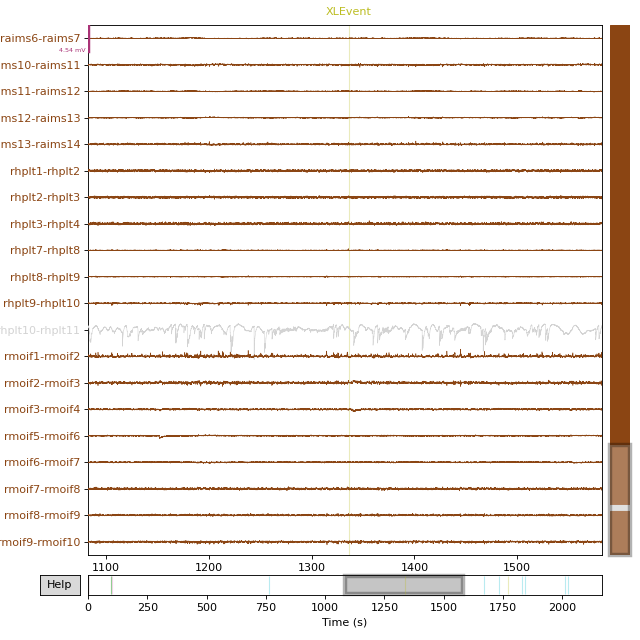

<IPython.core.display.Javascript object>


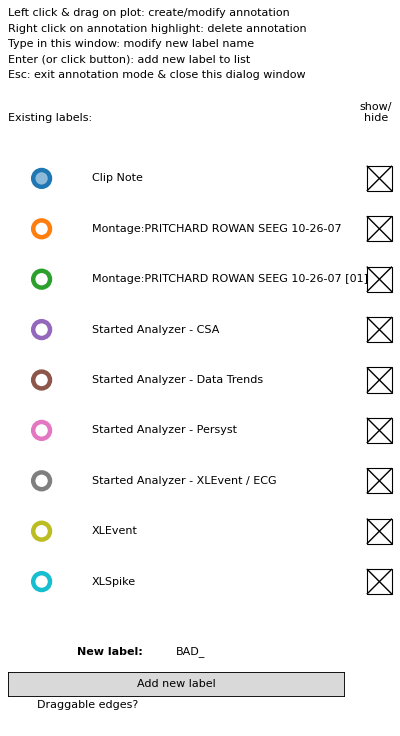

In [47]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=500, n_channels=20, scalings=mne_data_bp_reref._data.max()/5)
fig.fake_keypress('a')

Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


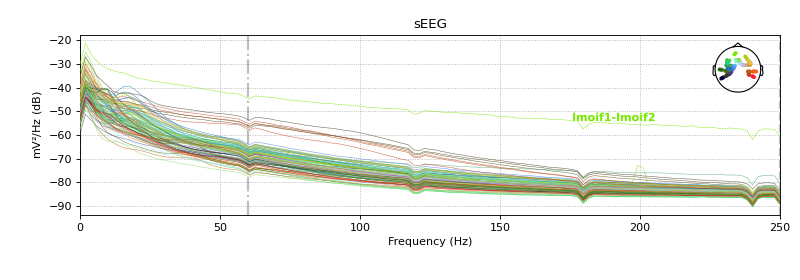

<IPython.core.display.Javascript object>


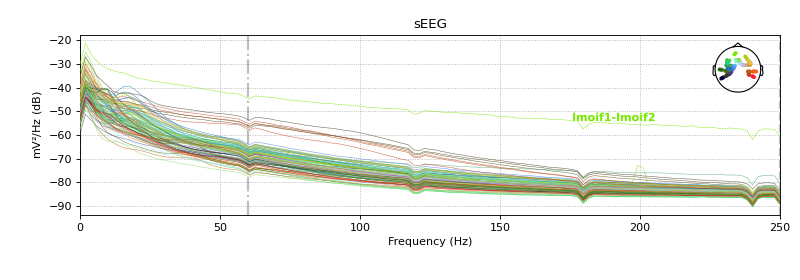

In [52]:
mne_data_bp_reref.compute_psd().plot() 

In [51]:
print(mne_data_bp_reref.info['bads'],date)

['rhplt10-rhplt11'] 05092024


## Save Reref Data

In [53]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/bp_ref_ieeg.fif
[done]


In [37]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

# Photodiode Alignment
SWB photodiodes should be aligned to TrialOnset
- extract TrialOnset times to align to photodiode deflection onset 
- clean photodiode data if necessary (if photodiode is inverted, noisy etc)
- align photodiode (if function fails, try manual alignment)
- verify proper alignment by plotting

In [68]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
behav_df

,Unnamed: 0,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,...,util_dCPE_emmap,util_tCF_emmap,util_dCF_emmap,util_tRegret_emmap,util_dRegret_emmap,util_tRelief_emmap,util_dRelief_emmap,util_RPE_emmap,util_pRPE_emmap,util_nRPE_emmap
0,0,1,25.0,mix,513.380590,513.390239,515.450091,515.457173,2.059852,0.0,...,-0.316691,0.316691,0.316691,-0.316691,-0.316691,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2,117.0,loss,522.640856,522.641563,524.596127,526.627092,1.954564,-0.3,...,-0.249038,0.000000,-0.904028,-1.153066,-0.249038,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,3,79.0,gain,531.174799,531.175599,532.759061,534.780269,1.583462,0.4,...,0.287099,0.000000,0.475010,0.000000,0.000000,0.762109,0.287099,0.000000,0.000000,0.000000
3,3,4,42.0,mix,545.592613,545.593355,548.084966,548.092333,2.491611,0.0,...,1.002813,-1.002813,-1.002813,0.000000,0.000000,1.002813,1.002813,0.000000,0.000000,0.000000
4,4,5,85.0,gain,555.337336,555.345720,557.114656,559.135069,1.768936,0.5,...,0.026058,0.000000,0.569423,0.000000,0.000000,0.595481,0.026058,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,144,146,135.0,loss,2082.720686,2082.729062,2087.254288,2089.276627,4.525226,-0.5,...,1.369044,-1.431695,-1.369044,0.000000,0.000000,1.431695,1.369044,1.431695,1.431695,0.000000
145,145,147,4.0,mix,2094.678701,2094.679411,2096.700082,2096.707465,2.020671,0.0,...,-0.112817,0.112817,0.112817,-0.112817,-0.112817,0.000000,0.000000,0.000000,0.000000,0.000000
146,146,148,136.0,loss,2107.766044,2107.770228,2110.494307,2112.504396,2.724080,-0.5,...,-0.211004,0.000000,-1.369044,-1.580049,-0.211004,0.000000,0.000000,0.000000,0.000000,0.000000
147,147,149,66.0,gain,2117.339199,2117.344685,2118.940681,2120.950084,1.595996,0.3,...,-0.376010,0.433963,0.376010,-0.433963,-0.376010,0.000000,0.000000,-0.433963,0.000000,-0.433963


In [70]:
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/photodiode.fif...
Isotrak not found
    Range : 0 ... 1083499 =      0.000 ...  2166.998 secs
Ready.
Reading 0 ... 1083499  =      0.000 ...  2166.998 secs...


In [71]:
photodiode_data

<Raw | photodiode.fif, 1 x 1083500 (2167.0 s), ~8.3 MB, data loaded>

<IPython.core.display.Javascript object>


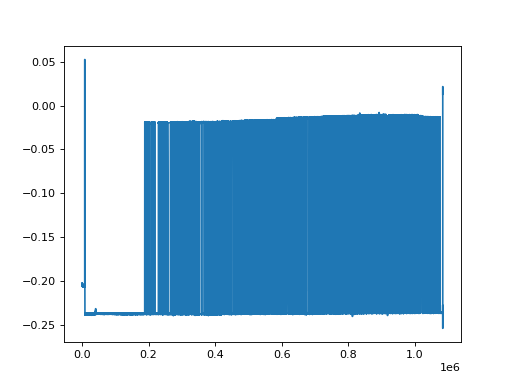

In [77]:
plt.plot(zscore(photodiode_data._data[0,:]))
plt.show()


In [78]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.7


# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, #
                                            smoothSize, windSize, height)

10 blocks
..........

found matches for 105 of 163 pulses


In [79]:
print(slope, offset,smoothSize,windSize,height)

0.999981019752198 17.49841978807069 11 15 0.7


In [65]:
# calculate pulse times from slope + offset
pulses = [(x*slope + offset) for x in beh_ts]
len(pulses) 

150

In [66]:
##### validate by plotting!
photo_sfreq = photodiode_data.info['sfreq']
photo_sfreq


500.0

<IPython.core.display.Javascript object>


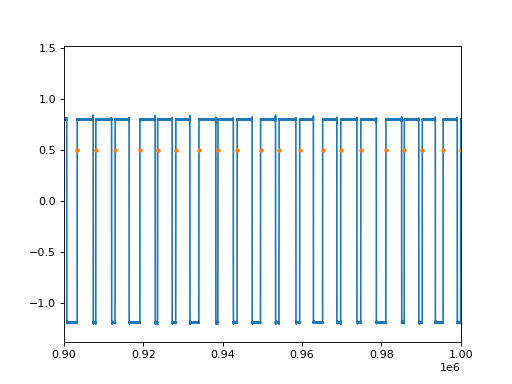

In [71]:
plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
plt.plot(np.array(pulses)*photo_sfreq, 
         np.ones_like(np.array(pulses)*photo_sfreq)-0.5, '.')

plt.xlim([900000,1000000])
plt.show()

In [85]:
# calculate pulse times from slope + offset
pulses = [(x*slope + offset) for x in beh_ts]
len(pulses) 

##### validate by plotting!
photo_sfreq = photodiode_data.info['sfreq']
photo_sfreq


plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
plt.plot(np.array(pulses)*photo_sfreq, 
         np.ones_like(np.array(pulses)*photo_sfreq)-0.5, '.')

plt.xlim([900000,1000000])
plt.show()

# Epoch Data
- Epoch neural data into trial epochs (and save df with IEDs/artifacts for every ev)
- Save epochs
- Baseline + decompose data into TFRs
- Add behavioral data to epochs metadata
- Plot + save TFRs (examine quality)

Note: Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
#### verify photodiode alignment by plotting trial ts and photodiode pulses
    # requires newer functions from new sync utils package (older version used for actual sync)

def get_neural_ts_photodiode(mne_sync, smoothSize=11, height=0.5):
    """
    get neural ts from photodiode
    """

    sig = np.squeeze(moving_average(mne_sync._data, n=smoothSize))
    timestamp = np.squeeze(np.arange(len(sig))/mne_sync.info['sfreq'])
    sig = scipy.stats.zscore(sig)

    trig_ix = np.where((sig[:-1]<=height)*(sig[1:]>height))[0] # rising edge of trigger
    
    neural_ts = timestamp[trig_ix]
    neural_ts = np.array(neural_ts)

    return neural_ts


def moving_average(a, n=11) :
    """
    Computes the moving average of a given array a with a window size of n.

    Parameters
    ----------
    a : np.ndarray
        The input array to compute the moving average on.
    n : int, optional
        The window size of the moving average. Default is 11.

    Returns
    -------
    np.ndarray
        The moving average of the input array a.
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


In [86]:
# calculate neural ts of photodiode events

neural_ts = get_neural_ts_photodiode(photodiode_data, smoothSize=15, height=0.7)
neural_ts.shape




(163,)

In [87]:
# calculate pulse times from slope + offset
pulses = [(x*slope + offset) for x in beh_ts]
len(pulses) 

149

In [94]:
##### validate by plotting!
photo_sfreq = photodiode_data.info['sfreq']
photo_sfreq


500.0

<IPython.core.display.Javascript object>


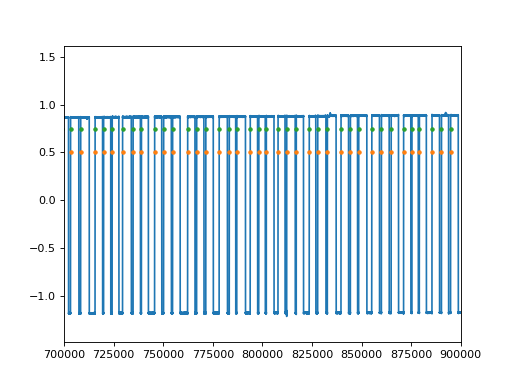

In [101]:
# # plt.plot(neural_ts,'o')
# plt.plot(pulses,'o')
# plt.show()

plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
plt.plot(np.array(pulses)*photo_sfreq, 
         np.ones_like(np.array(pulses)*photo_sfreq)-0.5, '.')
plt.plot(neural_ts*photo_sfreq, 
         np.ones_like(neural_ts)-0.25, '.')
plt.xlim([700000,900000])
plt.show()

In [102]:
print(slope, offset,smoothSize,windSize,height)

0.9999813358028993 17.49815119693244 11 15 0.7


# Epoch Data
- Epoch neural data into trial epochs (and save df with IEDs/artifacts for every ev)
- Save epochs
- Baseline + decompose data into TFRs
- Add behavioral data to epochs metadata
- Plot + save TFRs (examine quality)

Note: Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated


In [ ]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

### Get behavior ts for epochs of interest
- time points in SWB code are nonsensical - choice onset is a repeat of trial onset, and the difference between choice onset and decision onset is just the RT.
- even worse, feedback onset does not accurately mark feedback for safe choice trials - the feedback time is the safe outcome reveal, NOT counterfactual feedback. There is no true counterfactual feedback timestamp that's accurate for every trial. 
- Solution - make a new timestamp vector that is +2 seconds after DecisionOnset to use for counterfactual outcome feedback epochs


MAJOR UPDATE 05/09/2024 FROM PIPELINE UPDATE

In [103]:
#### load behavior data and define baseline/analysis epoch timepoints 

#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,util_dCPE_emmap,util_tCF_emmap,util_dCF_emmap,util_tRegret_emmap,util_dRegret_emmap,util_tRelief_emmap,util_dRelief_emmap,util_RPE_emmap,util_pRPE_emmap,util_nRPE_emmap
0,1,25.0,mix,513.380590,513.390239,515.450091,515.457173,2.059852,0.0,-1.10,...,-0.316691,0.316691,0.316691,-0.316691,-0.316691,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,117.0,loss,522.640856,522.641563,524.596127,526.627092,1.954564,-0.3,-0.95,...,-0.249038,0.000000,-0.904028,-1.153066,-0.249038,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,79.0,gain,531.174799,531.175599,532.759061,534.780269,1.583462,0.4,0.00,...,0.287099,0.000000,0.475010,0.000000,0.000000,0.762109,0.287099,0.000000,0.000000,0.000000
3,4,42.0,mix,545.592613,545.593355,548.084966,548.092333,2.491611,0.0,-0.80,...,1.002813,-1.002813,-1.002813,0.000000,0.000000,1.002813,1.002813,0.000000,0.000000,0.000000
4,5,85.0,gain,555.337336,555.345720,557.114656,559.135069,1.768936,0.5,0.00,...,0.026058,0.000000,0.569423,0.000000,0.000000,0.595481,0.026058,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,146,135.0,loss,2082.720686,2082.729062,2087.254288,2089.276627,4.525226,-0.5,-1.24,...,1.369044,-1.431695,-1.369044,0.000000,0.000000,1.431695,1.369044,1.431695,1.431695,0.000000
145,147,4.0,mix,2094.678701,2094.679411,2096.700082,2096.707465,2.020671,0.0,-0.30,...,-0.112817,0.112817,0.112817,-0.112817,-0.112817,0.000000,0.000000,0.000000,0.000000,0.000000
146,148,136.0,loss,2107.766044,2107.770228,2110.494307,2112.504396,2.724080,-0.5,-1.40,...,-0.211004,0.000000,-1.369044,-1.580049,-0.211004,0.000000,0.000000,0.000000,0.000000,0.000000
147,149,66.0,gain,2117.339199,2117.344685,2118.940681,2120.950084,1.595996,0.3,0.00,...,-0.376010,0.433963,0.376010,-0.433963,-0.376010,0.000000,0.000000,-0.433963,0.000000,-0.433963


In [107]:
list(zip(behav_df.GambleChoice,behav_df.DecisionOnset,behav_df.FeedbackOnset))

[('safe', 515.4500905999994, 515.4571732999993),
 ('gamble', 524.5961267000002, 526.6270924),
 ('gamble', 532.7590614000001, 534.7802687999992),
 ('safe', 548.0849658999996, 548.0923325999993),
 ('gamble', 557.1146561999994, 559.1350691999996),
 ('safe', 565.7605982000005, 565.7677017000005),
 ('gamble', 579.1231188999991, 581.1423699000006),
 ('safe', 588.2512723, 588.258966899999),
 ('gamble', 597.7967816, 599.8226211000001),
 ('gamble', 613.0223888, 615.0488946000005),
 ('gamble', 622.0351131999996, 624.0615366000002),
 ('safe', 631.4471295999992, 631.4541737),
 ('safe', 646.4570048000005, 646.4642236),
 ('gamble', 654.3205536999994, 656.3474817000006),
 ('gamble', 664.6992902999991, 666.7216286999992),
 ('safe', 679.9256103000007, 679.9326528999991),
 ('safe', 694.3864486000002, 694.3910804999996),
 ('safe', 709.2956604999981, 709.3027139999995),
 ('safe', 729.0705135000007, 0.0),
 ('safe', 734.0844855999985, 734.0919174999999),
 ('safe', 743.0299620999995, 743.037417900001),
 ('ga

In [111]:
behav_df['CpeOnset'] = behav_df.DecisionOnset + 2.0
behav_df['CpeOnset']

0       517.450091
1       526.596127
2       534.759061
3       550.084966
4       559.114656
          ...     
144    2089.254288
145    2098.700082
146    2112.494307
147    2120.940681
148    2130.152942
Name: CpeOnset, Length: 149, dtype: float64

## SWB Epochs:

**Baseline epoch** = 1 sec prior to trial onset \
**Decision epoch** = 0.5 sec prior to decision onset (choice epoch) \
**Feedback epoch** = 3 sec after CPE reveal \

*Outputs: Raw epoched data & IED + artifact dfs for every epoch*


In [116]:
# Define epochs of interest according to timestamps from behavior df 

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [117]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [118]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [119]:
### make epochs should now find IEDs, artifact times, and save info as df in load_path directory for every ev

for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                                                 slope=slope, offset=offset,
                                                 behav_name=event, behav_times=behav_df[event].values,
                                                 ev_start_s=evs[event][0], ev_end_s=evs[event][1],
                                                 buf_s = 1, IED_args=IED_args,
                                                 downsamp_factor=None,  
                                                 detrend=0) #### new - constant detrend by DC offset https://mne.tools/stable/generated/mne.Epochs.html

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/bp_ref_ieeg.fif...
    Range : 0 ... 1083499 =      0.000 ...  2166.998 secs
Ready.
Reading 0 ... 1083499  =      0.000 ...  2166.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.1s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 149 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/bp_ref_ieeg.fif...
    Range : 0 ... 1083499 =      0.000 ...  2166.998 secs
Ready.
Reading 0 ... 1083499  =      0.000 ...  2166.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.4s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 149 events and 1251 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/bp_ref_ieeg.fif...
    Range : 0 ... 1083499 =      0.000 ...  2166.998 secs
Ready.
Reading 0 ... 1083499  =      0.000 ...  2166.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.4s finished


Used Annotations descriptions: ['CpeOnset']
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 149 events and 2501 original time points ...
0 bad epochs dropped


In [125]:
epochs_all_evs 


{'TrialOnset': <Epochs |  149 events (all good), -2 - 1 sec, baseline off, ~164.0 MB, data loaded,
  'TrialOnset': 149>,
 'DecisionOnset': <Epochs |  149 events (all good), -1.5 - 1 sec, baseline off, ~136.7 MB, data loaded,
  'DecisionOnset': 149>,
 'CpeOnset': <Epochs |  149 events (all good), -1 - 4 sec, baseline off, ~273.1 MB, data loaded,
  'CpeOnset': 149>}

In [134]:
# to plot epochs if desired 
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')

### Add behavioral data to metadata

In [177]:
behav_params = ['Round','RT','CpeOnset','GambleChoice','TrialType',
                'SafeBet', 'LowBet', 'HighBet', 'GambleEV','Outcome',
                'Profit', 'TotalProfit', 'CR', 'choiceEV', 'RPE',
                'decisionCPE', 'decisionRegret','decisionRelief', 'decisionCF']

In [178]:
for event in evs.keys():

    event_metadata = pd.DataFrame(columns=behav_params)
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 19 columns
Replacing existing metadata with 19 columns
Replacing existing metadata with 19 columns


### Save raw epoched data 

In [179]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/{event}_epochs.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


In [180]:
epochs_all_evs

{'TrialOnset': <Epochs |  149 events (all good), -2 - 1 sec, baseline off, ~162.3 MB, data loaded, with metadata,
  'TrialOnset': 149>,
 'DecisionOnset': <Epochs |  149 events (all good), -1.5 - 1 sec, baseline off, ~136.7 MB, data loaded, with metadata,
  'DecisionOnset': 149>,
 'CpeOnset': <Epochs |  149 events (all good), -1 - 4 sec, baseline off, ~273.1 MB, data loaded, with metadata,
  'CpeOnset': 149>}

# Compute Baseline + Analysis TFRs
*Major updates 05/09/2024*
- Instead of removing entire epochs with IEDs, removing +/-100ms of IED or artifact timepoint 
- Now we have two analysis evs of interest - pre-decision epoch and cpe outcome epoch

In [181]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

baseline_ev  = 'TrialOnset' # fixation cross baseline epoch
analysis_evs = ['DecisionOnset','CpeOnset']

# dictionary of event ids and times - repeated from above
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [182]:
# Define spectrogram parameters for morlet wavelets 

freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


### Make Baseline TFR Epochs 

In [213]:
#### COMPUTE BASELINE TFRs 

# baseline epoch dictionary 
epochs_all_baseline = {} 

# baseline event = TrialOnset epochs 
baseline_epochs_reref = epochs_all_evs[baseline_ev]

# dropping bad channels from baseline epochs 
baseline_epochs_reref = baseline_epochs_reref.drop_channels(baseline_epochs_reref.info['bads'])

# compute baseline tfr 
temp_pow  = mne.time_frequency.tfr_morlet(baseline_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                          picks=baseline_epochs_reref.ch_names, # now doesn't include bad ch
                                          use_fft=True, n_jobs=-1, output='power',
                                          return_itc=False, average=False) # returns pow (not ITC) for all epochs

temp_pow.crop(tmin=evs[baseline_ev][0], tmax=evs[baseline_ev][1]) # clipping epoch to remove buffer

# Remove bad data by naning out +/-100ms around bad timepoints (IEDs and artifacts)
# THE following will now LOAD in dataframes that indicate IED and artifact time points in your data
IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_IED_df.csv') 
artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_artifact_df.csv') 

# iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
for ch_ix, ch_name in enumerate(baseline_epochs_reref.ch_names):
    # lists of IED/artifact timestamps from dfs for one channel (if any)
    ied_ev_list = IED_df[ch_name].dropna().index.tolist()
    artifact_ev_list = artifact_df[ch_name].dropna().index.tolist()
    
    # iterate through every IED timestamp in channel 
    for ev_ in ied_ev_list: 
        # iterate through values in IED df (literal eval = evaluates string as literal python data structures)
        for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((ied_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after 
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
    
    # iterate through every artifact timestamp in channel 
    for ev_ in artifact_ev_list: 
         # iterate through values in artifact df (literal eval = evaluates string as literal python data structures)
        for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

epochs_all_baseline[baseline_ev] = temp_pow


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   27.9s finished


Adding metadata with 19 columns


In [214]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 149, channels : 95, ~1.59 GB>}

### Compute Baseline-corrected TFRs for Analysis Epochs

In [215]:
#### COMPUTE ANALYSIS EVENT TFRs + BASELINE TO BASELINE TFRs 

# repeat baselining procedure for every event in analysis_evs
# remove +/-100ms around IED/artifact individually for each analysis epoch 
# baseline analysis ev tfrs
# iteratively check for zscores still above 10 std, remove those timepoints, then recompute baselined tfr


power_epochs = {} # keys = analysis evs 

for event in analysis_evs: 
    print('Compute baselined TFR for epoch: ',event)
    
    # extract raw epoch data for analysis ev 
    event_epochs_reref = epochs_all_evs[event].copy()
    # dropping bad channels from baseline epochs 
    event_epochs_reref = event_epochs_reref.drop_channels(event_epochs_reref.info['bads'])
    ch_names = event_epochs_reref.ch_names
    
    # compute TFR from raw epoched data
    temp_pow = mne.time_frequency.tfr_morlet(event_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                             picks=event_epochs_reref.ch_names, 
                                             use_fft=True, n_jobs=-1, output='power', 
                                             return_itc=False, average=False)
    # crop 1.0 sec buffer from analysis epoch 
    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
    
    ### repeat IED/artifact removal procedure used for baseline epochs, but with analysis event IED/artifact times
    
    # load IED/artifact dfs specific to event in analysis evs
    IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_IED_df.csv') 
    artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_artifact_df.csv') 
    
    # iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
    for ch_ix, ch_name in enumerate(event_epochs_reref.ch_names): 
        ied_ev_list = IED_df[ch_name].dropna().index.tolist()
        artifact_ev_list = artifact_df[ch_name].dropna().index.tolist() 
        for ev_ in ied_ev_list: 
            for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((ied_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
        for ev_ in artifact_ev_list: 
            for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

    ##### remove extreme power values (z>10) remaining after IED/artifact removal 
    # iterative process - baseline correct event TFR, remove z > 10, re-baseline until no z>10 or reached max iters
    
                
    # Let's nan out absurd z-scores (10 std above baseline???) that escaped our artifact detection, noise removal, and baselining
    absurdity_threshold = 10 # zscore threshold for removal
    max_iter = 10 # max number of iterations for while loop 
    large_z_flag=True # flag that indicates whether large zs are present, when all z<10 = False in while loop

    iteration = 0 # intialize iter counter
    while (large_z_flag==True) & (iteration<max_iter): # while z>10 still in tfr or under max iter num 
        print(f'baseline z-score iteration # {iteration}')
        # Baseline by all the baseline periods in the session
        baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                              baseline_mne=epochs_all_baseline[baseline_ev].data,  
                              mode='zscore', ev_axis=0, elec_axis=1, freq_axis=2, time_axis=3)

        large_z_mask = np.where(baseline_corrected_power>absurdity_threshold)
        if large_z_mask[0].shape[0] == 0:
            # no more large z
            large_z_flag = False
        else:
            # NaN it out in the event of interest prior to re-running the baseline z-score to prevent
            # contamination of all z's
            temp_pow.data[large_z_mask] = np.nan

        iteration +=1
    
    # input baseline corrected pow into mne EpochsTFR object once all z>10 removed or iteratively removed 10x 
    zpow = mne.time_frequency.EpochsTFR(event_epochs_reref.info, baseline_corrected_power,
                                        temp_pow.times, freqs)
    
    # add metadata to baseline corrected TFR event epochs object 
    zpow.metadata = event_epochs_reref.metadata
    
    # save data (#conda install -c conda-forge h5io must install to save tfr data)
    zpow.save(f'{neural_dir}{subj_id}/{subj_id}_{event}-tfr.h5', overwrite=True) 
    
    # store event zpow epochs in dict for all analysis evs 
    power_epochs[event] = zpow
    

Compute baselined TFR for epoch:  DecisionOnset


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   26.2s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
Not setting metadata
Adding metadata with 19 columns
Compute baselined TFR for epoch:  CpeOnset


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   38.8s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
baseline z-score iteration # 7
Not setting metadata
Adding metadata with 19 columns


In [216]:
power_epochs

{'DecisionOnset': <EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 149, channels : 95, ~813.4 MB>,
 'CpeOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 149, channels : 95, ~4.75 GB>}

In [217]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 149, channels : 95, ~813.4 MB>

In [218]:
power_epochs['CpeOnset']

<EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 149, channels : 95, ~4.75 GB>

# Plot TFRs 
- For each analysis event, plot the mean TFR across all epochs for all channels
- Save plots
- Visually inspect TFRs to see if further data cleaning is necessary

In [233]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/single_elec_tfrs/{subj_id}/'

# print date of TFR plotting 
date = datetime.date.today().strftime('%m%d%Y')
print(date, offset) # print date, double check current slope/offset


05102024 17.49815119693244


In [ ]:
#### for each analysis event - plot one TFR averaged across all epochs for every electrode & save 

for event in analysis_evs: 
    print('Plot TFR for epoch: ',event)
    save_path = f'{tfr_dir}{event}/'
    os.makedirs(save_path,exist_ok = True) #added so you don't have to manually make folders
    
    ev_data = power_epochs[event].copy() # tfr plot data - epochs x num ch x freqs x times 
    times = ev_data.times.copy() # same for all elec
    
    for ch in ev_data.ch_names:
        # single ch tfr 
        plot_data = np.nanmean(np.nanmean(ev_data.copy().pick_channels([ch]).data, axis=0), axis=0) 
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 4),dpi=300)
        
        im = ax.imshow(plot_data,interpolation='Bicubic',
                       aspect='auto', origin='lower', cmap='RdBu_r')
    

        ax.set(xlabel='Time (s)', ylabel='Frequency (Hz)',title=f'{subj_id}_{ch}_{event}_{date}',
               yticks=np.arange(0,len(freqs))[::5], 
               yticklabels=freqs[::5].astype(int), 
               xticks = np.arange(plot_data.shape[1])[::250],
                  xticklabels= times[::250])
        
        fig.colorbar(im, ax=ax)

        plt.savefig(f'{save_path}{subj_id}_{ch}_{event}_{date}.png', dpi=300)
#         bbox_inches=None, pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',backend=None)
        plt.close()

    

Plot TFR for epoch:  DecisionOnset
